In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mutual_info_score, confusion_matrix
from sklearn import tree
#import xgboost as xgb
from xgboost import XGBClassifier
import pickle 

### Kaggle file on https://www.kaggle.com/datasets/rajatsurana979/hotel-reservation-data-repository?select=hotel_booking.csv
### Focus on XGBoost - that's supposed to be the best for tabular data in general.

#### The goal will be to determine whether we can predict if a hotel reserveration will get cancelled (is_canceled) based on booking characteristics such as number of people, type of hotel, type of payment etc... Note there is 1 more column called "reservation_status" which also says whether a reservation got cancelled and we will exclude that. 

In [2]:
df = pd.read_csv("hotel_booking.csv")

In [3]:
df.columns = df.columns.str.replace("-", "_")

In [4]:
df.columns = df.columns.str.replace(" ", "_")

In [5]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country_code', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone_number', 'credit_card'],
      dtype='object')

In [6]:
numerical = ["lead_time", "previous_bookings_not_canceled", "adr", "required_car_parking_spaces", "stays_in_weekend_nights", 
             "total_of_special_requests", "stays_in_week_nights", "adults", "children", "babies", "previous_cancellations", "previous_bookings_not_canceled",
            "booking_changes", "days_in_waiting_list"]
categorical = [ "hotel", "deposit_type", "customer_type", "arrival_date_year", "arrival_date_month", "arrival_date_week_number", "meal", "country_code", "market_segment", "distribution_channel",
              "is_repeated_guest", "reserved_room_type", "assigned_room_type"]
df[numerical+categorical].head(1)


,lead_time,previous_bookings_not_canceled,adr,required_car_parking_spaces,stays_in_weekend_nights,total_of_special_requests,stays_in_week_nights,adults,children,babies,...,arrival_date_year,arrival_date_month,arrival_date_week_number,meal,country_code,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type
0,342,0,0.0,0,0,0,0,2,0.0,0,...,2015,July,27,BB,PRT,Direct,Direct,0,C,C


## Split the data and then explore

In [7]:
df_fulltrain, df_test = train_test_split(df, test_size=.2, random_state=11)


## Exploratory Data Analysis

In [8]:
global_cancel = df_fulltrain.is_canceled.mean()
global_cancel

0.36947189881899656

In [9]:
df_fulltrain["hotel"].value_counts()

hotel
City Hotel      63456
Resort Hotel    32056
Name: count, dtype: int64

In [10]:
df_fulltrain[df_fulltrain["hotel"]== "Resort Hotel"].is_canceled.mean()

0.2772335912153731

In [11]:
df_fulltrain[df_fulltrain["hotel"]== "City Hotel"].is_canceled.mean()

0.4160678265254665

### Correlations, Mutual Info

In [12]:
for c in categorical:
    df_group = df_fulltrain.groupby(c).is_canceled.agg(["mean", "count"])
    df_group["diff"] = df_group["mean"] - global_cancel
    df_group["risk"] = df_group["mean"] / global_cancel
    display(df_group)

,mean,count,diff,risk
hotel,,,,
City Hotel,0.416068,63456,0.046596,1.126115
Resort Hotel,0.277234,32056,-0.092238,0.750351


,mean,count,diff,risk
deposit_type,,,,
No Deposit,0.282628,83700,-0.086843,0.764952
Non Refund,0.993493,11680,0.624021,2.688955
Refundable,0.219697,132,-0.149775,0.594624


,mean,count,diff,risk
customer_type,,,,
Contract,0.315094,3253,-0.054378,0.852822
Group,0.111597,457,-0.257875,0.302046
Transient,0.405946,71608,0.036474,1.098720
Transient-Party,0.254729,20194,-0.114743,0.689441


,mean,count,diff,risk
arrival_date_year,,,,
2015,0.372110,17648,0.002638,1.007141
2016,0.356316,45440,-0.013156,0.964393
2017,0.386473,32424,0.017001,1.046015


,mean,count,diff,risk
arrival_date_month,,,,
April,0.406747,8922,0.037275,1.100889
August,0.378187,11177,0.008715,1.023589
December,0.345743,5426,-0.023729,0.935775
February,0.333074,6419,-0.036398,0.901486
January,0.304366,4741,-0.065106,0.823787
July,0.374186,10134,0.004714,1.012759
June,0.413211,8705,0.043739,1.118382
March,0.321585,7774,-0.047887,0.870390
May,0.394341,9436,0.024869,1.067309


,mean,count,diff,risk
arrival_date_week_number,,,,
1,0.344828,841,-0.024644,0.933299
2,0.321897,991,-0.047575,0.871236
3,0.242424,1056,-0.127048,0.656137
4,0.339897,1168,-0.029575,0.919954
5,0.309631,1111,-0.059841,0.838037
6,0.248976,1221,-0.120496,0.673871
7,0.325076,1655,-0.044396,0.879838
8,0.357020,1745,-0.012452,0.966298
9,0.344646,1709,-0.024826,0.932807


,mean,count,diff,risk
meal,,,,
BB,0.372839,73820,0.003367,1.009114
FB,0.597179,638,0.227707,1.616303
HB,0.345411,11592,-0.024061,0.934877
SC,0.369887,8508,0.000415,1.001124
Undefined,0.245283,954,-0.124189,0.663875


,mean,count,diff,risk
country_code,,,,
ABW,0.000000,2,-0.369472,0.000000
AGO,0.589744,273,0.220272,1.596180
AIA,0.000000,1,-0.369472,0.000000
ALB,0.100000,10,-0.269472,0.270657
AND,0.833333,6,0.463861,2.255471
...,...,...,...,...
VGB,1.000000,1,0.630528,2.706566
VNM,0.285714,7,-0.083758,0.773305
ZAF,0.358209,67,-0.011263,0.969516


,mean,count,diff,risk
market_segment,,,,
Aviation,0.203125,192,-0.166347,0.549771
Complementary,0.125850,588,-0.243622,0.340622
Corporate,0.187426,4199,-0.182046,0.507280
Direct,0.151802,10125,-0.217669,0.410863
Groups,0.610616,15920,0.241144,1.652671
Offline TA/TO,0.343207,19379,-0.026265,0.928911
Online TA,0.365309,45107,-0.004163,0.988733
Undefined,1.000000,2,0.630528,2.706566


,mean,count,diff,risk
distribution_channel,,,,
Corporate,0.221595,5316,-0.147877,0.599762
Direct,0.172819,11758,-0.196653,0.467745
GDS,0.182927,164,-0.186545,0.495103
TA/TO,0.409416,78270,0.039944,1.108112
Undefined,1.000000,4,0.630528,2.706566


,mean,count,diff,risk
is_repeated_guest,,,,
0,0.376707,92475,0.007235,1.019583
1,0.149160,3037,-0.220312,0.403712


,mean,count,diff,risk
reserved_room_type,,,,
A,0.390695,68890,0.021223,1.057443
B,0.333333,894,-0.036139,0.902189
C,0.327078,746,-0.042394,0.885257
D,0.314673,15362,-0.054799,0.851682
E,0.289683,5147,-0.079789,0.784047
F,0.304704,2317,-0.064768,0.824702
G,0.359517,1655,-0.009955,0.973055
H,0.400411,487,0.030939,1.083738
L,0.400000,5,0.030528,1.082626


,mean,count,diff,risk
assigned_room_type,,,,
A,0.444699,59303,0.075227,1.203608
B,0.237201,1758,-0.132271,0.642001
C,0.189390,1885,-0.180082,0.512596
D,0.248582,20271,-0.120890,0.672803
E,0.248502,6173,-0.120970,0.672586
F,0.247498,2998,-0.121974,0.669871
G,0.301193,2012,-0.068279,0.815198
H,0.341338,583,-0.028134,0.923854
I,0.013468,297,-0.356004,0.036452


### FillNA using the most common categorical value

In [13]:
mode_values = df_fulltrain[categorical].mode().iloc[0]
mode_values


hotel                       City Hotel
deposit_type                No Deposit
customer_type                Transient
arrival_date_year                 2016
arrival_date_month              August
arrival_date_week_number            33
meal                                BB
country_code                       PRT
market_segment               Online TA
distribution_channel             TA/TO
is_repeated_guest                    0
reserved_room_type                   A
assigned_room_type                   A
Name: 0, dtype: object

In [14]:
df_fulltrain[categorical] = df_fulltrain[categorical].fillna(mode_values)
df_test[categorical] = df_test[categorical].fillna(mode_values)


In [15]:
def get_mutual_info_score(series):
    return mutual_info_score(series, df_fulltrain.is_canceled)

df_fulltrain[categorical].apply(get_mutual_info_score)

hotel                       0.009442
deposit_type                0.131364
customer_type               0.009470
arrival_date_year           0.000390
arrival_date_month          0.002409
arrival_date_week_number    0.004924
meal                        0.001232
country_code                0.065623
market_segment              0.037066
distribution_channel        0.017254
is_repeated_guest           0.003914
reserved_room_type          0.002906
assigned_room_type          0.022205
dtype: float64

In [16]:
df_fulltrain[numerical].corrwith(df_fulltrain["is_canceled"]).abs().sort_values()

stays_in_weekend_nights           0.001997
children                          0.005650
stays_in_week_nights              0.024147
babies                            0.032657
adr                               0.047448
days_in_waiting_list              0.052663
previous_bookings_not_canceled    0.056820
previous_bookings_not_canceled    0.056820
adults                            0.058753
previous_cancellations            0.110555
booking_changes                   0.145328
required_car_parking_spaces       0.194960
total_of_special_requests         0.236329
lead_time                         0.292262
dtype: float64

In [17]:
df_fulltrain.head().T

,117812,57446,95533,79914,114628
hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel
is_canceled,0,1,0,0,0
lead_time,3,80,320,2,109
arrival_date_year,2017,2016,2016,2015,2017
arrival_date_month,August,September,August,November,June
arrival_date_week_number,32,40,34,45,25
arrival_date_day_of_month,7,26,18,6,22
stays_in_weekend_nights,1,1,0,0,0
stays_in_week_nights,2,2,2,1,3
adults,2,2,1,2,2


In [18]:
# The goal of the project is to determine whether a booking is going to be cancelled
df_fulltrain.nunique()

hotel                                 2
is_canceled                           2
lead_time                           478
arrival_date_year                     3
arrival_date_month                   12
arrival_date_week_number             53
arrival_date_day_of_month            31
stays_in_weekend_nights              17
stays_in_week_nights                 34
adults                               14
children                              5
babies                                5
meal                                  5
country_code                        171
market_segment                        8
distribution_channel                  5
is_repeated_guest                     2
previous_cancellations               15
previous_bookings_not_canceled       67
reserved_room_type                   10
assigned_room_type                   12
booking_changes                      21
deposit_type                          3
agent                               324
company                             338


In [19]:
df_fulltrain.isna().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country_code                          0
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             13047
company                           90137


### lead_time

In [20]:
df_fulltrain.lead_time.describe()

count    95512.000000
mean       103.713795
std        106.581769
min          0.000000
25%         18.000000
50%         69.000000
75%        160.000000
max        737.000000
Name: lead_time, dtype: float64

/Users/naveed/miniconda3/envs/mlz1/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/naveed/miniconda3/envs/mlz1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='lead_time', ylabel='Count'>

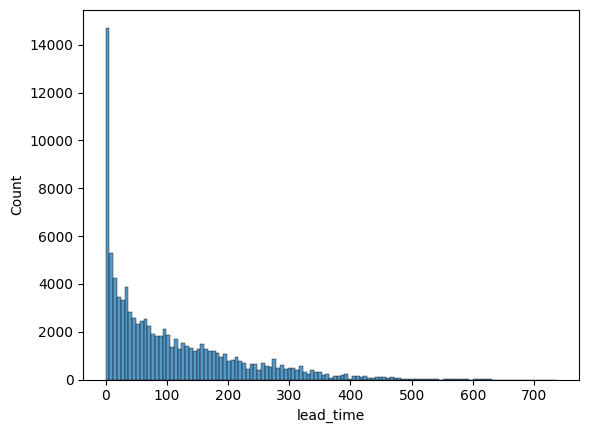

In [21]:
sns.histplot(df_fulltrain.lead_time)

/Users/naveed/miniconda3/envs/mlz1/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/naveed/miniconda3/envs/mlz1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='lead_time', ylabel='Count'>

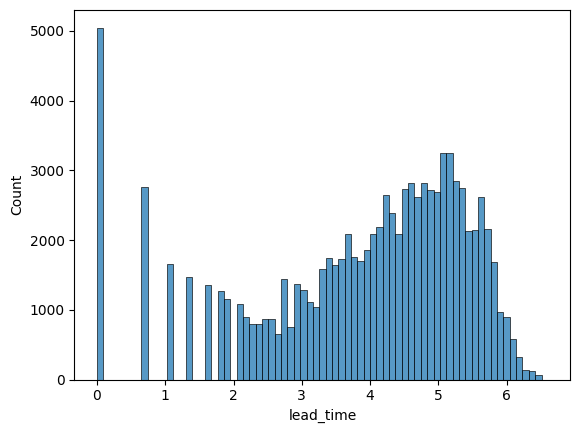

In [22]:
sns.histplot(np.log1p(df_fulltrain.lead_time))

### Feature Engineering 1

In [23]:
df_fulltrain.lead_time = np.log1p(df_fulltrain.lead_time)
df_test.lead_time = np.log1p(df_test.lead_time)

In [24]:
df_fulltrain.country_code.head()

117812    PRT
57446     PRT
95533     DEU
79914     ITA
114628    PRT
Name: country_code, dtype: object

In [25]:
df_fulltrain.company.head(5)

117812   NaN
57446    NaN
95533    NaN
79914    NaN
114628   NaN
Name: company, dtype: float64

In [26]:
df_fulltrain.days_in_waiting_list.describe()

count    95512.000000
mean         2.288979
std         17.072614
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        391.000000
Name: days_in_waiting_list, dtype: float64

/Users/naveed/miniconda3/envs/mlz1/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/naveed/miniconda3/envs/mlz1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='days_in_waiting_list', ylabel='Count'>

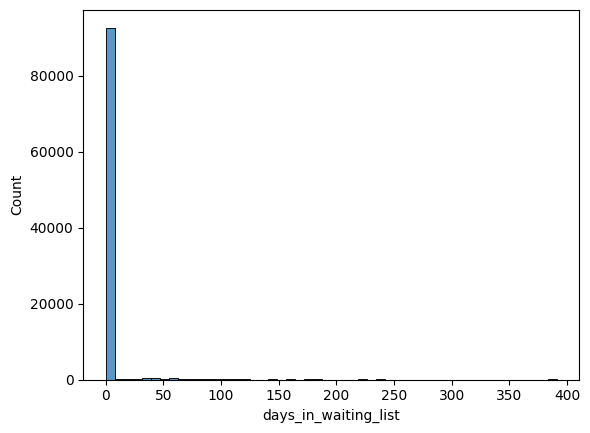

In [27]:
#seems this one will be miisleading as it currently is. 0 can mean no waiting list existed. 
sns.histplot(df_fulltrain.days_in_waiting_list, bins=50)

### Feature Engineering 2 & 3

In [28]:
### Add 2 new variables to reduce category cardinality but keep the data 
df_fulltrain["wait_listed"] = df_fulltrain["days_in_waiting_list"] > 0
df_test["wait_listed"] = df_test["days_in_waiting_list"] > 0

In [29]:
df_fulltrain["wait_listed"].value_counts()

wait_listed
False    92544
True      2968
Name: count, dtype: int64

In [30]:
df_fulltrain["different_room_type"] = df_fulltrain["reserved_room_type"] != df_fulltrain["assigned_room_type"]
df_test["different_room_type"] = df_test["reserved_room_type"] != df_test["assigned_room_type"]

In [31]:
df_fulltrain["different_room_type"].value_counts()

different_room_type
False    83562
True     11950
Name: count, dtype: int64

## Pick the final features and start training

In [33]:
final_numerical = ["adults", "lead_time", "previous_cancellations", "previous_bookings_not_canceled", "booking_changes", "adr", "required_car_parking_spaces", "total_of_special_requests"]
final_categorical = [ "hotel", "deposit_type", "customer_type", "different_room_type", "arrival_date_month", "wait_listed"]
        
df_test[final_numerical+final_categorical]
df_fulltrain[final_numerical+final_categorical]


,adults,lead_time,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,required_car_parking_spaces,total_of_special_requests,hotel,deposit_type,customer_type,different_room_type,arrival_date_month,wait_listed
117812,2,1.386294,0,0,0,169.0,0,0,City Hotel,No Deposit,Transient,False,August,False
57446,2,4.394449,0,0,0,75.0,0,0,City Hotel,No Deposit,Transient-Party,False,September,False
95533,1,5.771441,0,0,1,90.0,0,0,City Hotel,No Deposit,Transient-Party,True,August,False
79914,2,1.098612,0,0,0,107.0,0,1,City Hotel,No Deposit,Contract,False,November,False
114628,2,4.700480,0,0,0,108.0,0,2,City Hotel,No Deposit,Transient,False,June,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97617,2,4.356709,0,0,0,149.4,0,1,City Hotel,No Deposit,Transient,False,September,False
72795,2,5.765191,0,0,0,80.1,0,0,City Hotel,No Deposit,Transient,False,August,False
21584,2,2.484907,0,0,0,48.0,0,0,Resort Hotel,No Deposit,Transient,True,March,False
36543,1,2.484907,0,0,0,58.0,1,1,Resort Hotel,No Deposit,Transient,True,May,False


In [34]:
# pass it into XGBoost that thse are categorical
for c in final_categorical:
    df_fulltrain[c] = df_fulltrain[c].astype('category')
    df_test[c] = df_test[c].astype('category')
df_fulltrain.dtypes

hotel                             category
is_canceled                          int64
lead_time                          float64
arrival_date_year                    int64
arrival_date_month                category
arrival_date_week_number             int64
arrival_date_day_of_month            int64
stays_in_weekend_nights              int64
stays_in_week_nights                 int64
adults                               int64
children                           float64
babies                               int64
meal                                object
country_code                        object
market_segment                      object
distribution_channel                object
is_repeated_guest                    int64
previous_cancellations               int64
previous_bookings_not_canceled       int64
reserved_room_type                  object
assigned_room_type                  object
booking_changes                      int64
deposit_type                      category
agent      

In [35]:
df_test = df_test[final_numerical+final_categorical+["is_canceled"]]
df_fulltrain = df_fulltrain[final_numerical+final_categorical+["is_canceled"]]

## Now prepare for training

In [36]:
df_train, df_val = train_test_split(df_fulltrain, test_size=.25, random_state=1)

In [37]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [38]:
y_train = df_train["is_canceled"].values
y_val = df_val["is_canceled"].values
y_test = df_test["is_canceled"].values
del df_train["is_canceled"]
del df_val["is_canceled"]
del df_test["is_canceled"]

## Training a model

In [39]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [40]:
features = dv.get_feature_names_out()
features = list(features)

In [41]:
features

['adr',
 'adults',
 'arrival_date_month=April',
 'arrival_date_month=August',
 'arrival_date_month=December',
 'arrival_date_month=February',
 'arrival_date_month=January',
 'arrival_date_month=July',
 'arrival_date_month=June',
 'arrival_date_month=March',
 'arrival_date_month=May',
 'arrival_date_month=November',
 'arrival_date_month=October',
 'arrival_date_month=September',
 'booking_changes',
 'customer_type=Contract',
 'customer_type=Group',
 'customer_type=Transient',
 'customer_type=Transient-Party',
 'deposit_type=No Deposit',
 'deposit_type=Non Refund',
 'deposit_type=Refundable',
 'different_room_type',
 'hotel=City Hotel',
 'hotel=Resort Hotel',
 'lead_time',
 'previous_bookings_not_canceled',
 'previous_cancellations',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'wait_listed']

In [42]:

model = XGBClassifier(n_estimators=111, max_depth=11, learning_rate=.3, objective='binary:logistic', enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=111, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
# dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
# dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
# watchlist = [(dtrain, "train"), (dval, "val")]
# xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [44]:
df_fulltrain.dtypes

adults                               int64
lead_time                          float64
previous_cancellations               int64
previous_bookings_not_canceled       int64
booking_changes                      int64
adr                                float64
required_car_parking_spaces          int64
total_of_special_requests            int64
hotel                             category
deposit_type                      category
customer_type                     category
different_room_type               category
arrival_date_month                category
wait_listed                       category
is_canceled                          int64
dtype: object

In [45]:

y_pred = model.predict_proba(X_val)


In [46]:
roc_auc_score(y_test, y_pred[:,1])

0.5017942121490502

### Try tuning parameters

In [75]:
def train_fit_model(min_child_weight, max_depth, lr): 
    model = XGBClassifier(min_child_weight = min_child_weight, max_depth=max_depth, learning_rate=lr, objective='binary:logistic', enable_categorical=True)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)
    return roc_auc_score(y_test, y_pred[:,1]), model


In [69]:
lr_list = np.arange(.1, 1.1, .2)

In [70]:
min_child_weight_list = np.arange(1, 200, 21)

In [71]:
max_depth_list = np.arange(1, 200, 21)

In [76]:
result = []
for lr in lr_list:
    for mcw in min_child_weight_list:
        for md in max_depth_list:
            auc, _ = train_fit_model(mcw, md, lr)
            result.append({"auc": auc,  "min_child_weight" : mcw, "learning_rate" : lr, "max_depth" : md })
df_result = pd.DataFrame(result)
df_result.sort_values("auc", ascending=False)

,auc,min_child_weight,learning_rate,max_depth
181,0.504262,169,0.3,22
291,0.504094,190,0.5,22
371,0.504083,148,0.7,22
297,0.504049,190,0.5,148
298,0.504049,190,0.5,169
...,...,...,...,...
304,0.499100,1,0.7,85
305,0.499100,1,0.7,106
306,0.499100,1,0.7,127
309,0.499100,1,0.7,190


In [79]:
final_auc, model = train_fit_model(169, 22, .3)

In [80]:
final_auc

0.5042619181016945

In [93]:
y_pred = model.predict(X_val)
y_pred
confusion_matrix(y_val, y_pred)

array([[13701,  1385],
       [ 2865,  5927]])

In [ ]:
# save the model
output_file = "model.bin"
with open(output_file, "wb") as f_out:
    pickle.dump((dv, model), f_out)

## Try loading the model and running a single customer

In [ ]:

import pickle

with open("model.bin", "rb") as f_in:
    dv, model = pickle.load(f_in)

In [ ]:
df_val.iloc[0]

In [ ]:
df_val.iloc[0].to_dict()

In [ ]:
df_val.iloc[0].to_json()

In [ ]:
customer = df_val.iloc[0].to_dict()

In [ ]:
X = dv.transform([customer])

In [ ]:
model.predict_proba(X)[0, 1]

In [ ]:
!pip install fastapi

In [ ]:
!pip install pydantic